In [1]:
#### library package
pacman::p_load(Seurat, dplyr, ggplot2, stringr, magrittr, reticulate, reshape2, tidyverse, ggsci, knitr, harmony, cowplot, RColorBrewer, anndata,
               tidyr, patchwork, ggrepel, homologene, scico, DropletUtils, scCustomize, tidydr, Matrix, DoubletFinder, data.table, ggpubr, 
               ggthemes, extrafont, sysfonts, viridis, openxlsx, paletteer)

[1] 842169

# load data

In [ ]:
data1 <- load3CAdata('/project/sex_cancer/data/CRC_Pelka2021/Group1')
data2 <- load3CAdata('/project/sex_cancer/data/CRC_Pelka2021/Group2')
data3 <- load3CAdata('/project/sex_cancer/data/CRC_Pelka2021/Group3')
data4 <- load3CAdata('/project/sex_cancer/data/CRC_Pelka2021/Group4')
obj.CRC <- merge(data1, c(data2, data3, data4)) %>% UpdateSeuratObject()

In [1]:
## add sample info
sample_info <- read.csv('/project/sex_cancer/data/CRC_Pelka2021/GSE178341_crc10x_full_c295v4_submit_metatables.csv')

In [5]:
## add cell type annotation
cell_anno <- read.csv('/project/sex_cancer/data/CRC_Pelka2021/crc10x_full_c295v4_submit_cluster.csv')
nrow(cell_anno)
cell_anno %>% head(n = 2)

[1] 370115

,sampleID,batchID,clTopLevel,clMidwayPr,cl295v11SubShort,cl295v11SubFull
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
2,C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)


In [2]:
## modify meat.data
meta_data <- cbind(sample_info %>% transform(barcode = cellID) %>% column_to_rownames('cellID'),
                   cell_anno %>% column_to_rownames('sampleID')) %>%
             dplyr::rename(c('oCT' = 'clMidwayPr', 'dCT' = 'cl295v11SubFull',
                             'SampleID' = 'PatientTypeID', 'DonorID' = 'PID')) %>%
             transform(SampleType = ifelse(SPECIMEN_TYPE == 'T', 'tumor', 'normal_adjacent')) %>%
             transform(Cohort = 'CRC_Pelka2021') %>% 
             mutate(Chemistry = case_when(SINGLECELL_TYPE == 'SC3Pv2' ~ "10x 3' v2",
                                          SINGLECELL_TYPE == 'SC3Pv3' ~ "10x 3' v3",
                                          TRUE ~ 'unknown')) %>%
             .[colnames(obj.CRC),]
obj.CRC@meta.data <- meta_data

In [93]:
obj.CRC@meta.data[,c('SampleType', 'SampleID', 'Sex', 'MetastasisStatus')] %>% .[!duplicated(.$SampleID),] %$% table(.$Sex, .$SampleType, useNA = 'ifany')
obj.CRC@meta.data %$% table(.$SampleType)

   
    normal_adjacent tumor
  F              17    32
  M              19    32


normal_adjacent           tumor 
         112864          257251 

# cell type annotation

## assign mCT

In [107]:
obj.CRC@meta.data <- obj.CRC@meta.data %>%
                     mutate(mCT = case_when(oCT %in% c('Epi') ~ 'Epi', ## 这里包括了正常上皮
                                            oCT %in% c('TCD8') ~ 'CD8T',
                                            (oCT == 'TCD4' & dCT %in% c("cTNI08 (CD4+ Treg)", "cTNI09 (CD4+ Treg prolif)") == FALSE) ~ 'CD4T',
                                            dCT %in% c("cTNI08 (CD4+ Treg)", "cTNI09 (CD4+ Treg prolif)") ~ 'Treg',
                                            oCT %in% c('TZBTB16') ~ 'T_ZBTB16',
                                            oCT %in% c('Tgd') ~ 'γδT',
                                            oCT %in% c('Macro') ~ 'Mph',
                                            oCT %in% c('Granulo') ~ 'Neu',
                                            oCT %in% c('SmoothMuscle') ~ 'SMC',
                                            oCT %in% c('Peri') ~ 'Pericyte',
                                            oCT %in% c('Plasma', 'B') ~ 'B',
                                            TRUE ~ oCT # DC NK Endo Mono B Mast ILC Schwann
                                            ))
unique(obj.CRC$mCT)

[1] "Epi"      "CD4T"     "Pericyte" "Mph"      "Treg"     "DC"      
 [7] "NK"       "Endo"     "Mono"     "Fibro"    "CD8T"     "B"       
[13] "Mast"     "T_ZBTB16" "γδT"      "Neu"      "ILC"      "SMC"     
[19] "Schwann"

## assign gCT

In [108]:
obj.CRC@meta.data <- obj.CRC@meta.data %>%
                     mutate(gCT = case_when(mCT %in% c('Epi') ~ 'Tumor', 
                                            mCT %in% c('CD4T', 'Mph', 'Treg', 'DC', 'NK', 'Mono', 'CD8T', 'B', 'Mast', 'T_ZBTB16', 'γδT', 'Neu', 'ILC') ~ 'Immune',
                                            mCT %in% c('Pericyte', 'Endo', 'Fibro', 'SMC', 'Schwann') ~ 'Stromal',
                                            TRUE ~ 'Others'
                                            ))
table(obj.CRC$mCT, obj.CRC$gCT, useNA = 'ifany')

          
           Immune Stromal  Tumor
  B         63469       0      0
  CD4T      22848       0      0
  CD8T      23486       0      0
  DC         5549       0      0
  Endo          0    7520      0
  Epi           0       0 168295
  Fibro         0    5231      0
  ILC         832       0      0
  Mast       3834       0      0
  Mono      14242       0      0
  Mph       20280       0      0
  Neu        2043       0      0
  NK         3924       0      0
  Pericyte      0    1525      0
  Schwann       0     281      0
  SMC           0     881      0
  T_ZBTB16   4742       0      0
  Treg      11750       0      0
  γδT        9383       0      0

# run UMAP

In [3]:
# add nCount
nCount_RNA <- colSums(x = obj.CRC, slot = "counts")
obj.CRC <- obj.CRC %>% AddMetaData(metadata = nCount_RNA, col.name = 'nCount_RNA')
obj.CRC@meta.data %>% head(n = 2)

,barcode,SampleID,SampleType,Cohort,DonorID,Sex,Age,Differentiation,Tumor_size_cm,Chemistry,gCT,mCT,dCT,oCT,StageI,nCount_RNA
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT,C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT,C103_T,tumor,CRC_Pelka2021,C103,M,45,low,2.5,10x 3' v2,Tumor,Epi,cE01 (Stem/TA-like),Epi,pT2,15093
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT,C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT,C103_T,tumor,CRC_Pelka2021,C103,M,45,low,2.5,10x 3' v2,Tumor,Epi,cE01 (Stem/TA-like),Epi,pT2,1156


In [3]:
# run harmony
obj.CRC <- obj.CRC %>%
           NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000, verbose = F) %>%
           FindVariableFeatures(selection.method = "vst", nfeatures = 3000, verbose = F) %>%
           ScaleData(vars.to.regress = c("nCount_RNA"), verbose = F) %>% 
           RunPCA(verbose = F)  %>% 
           RunHarmony(group.by.vars = "SampleID", plot_convergence = TRUE)

In [4]:
# run UMAP
nPC <- min(PC_selection_harmony(obj.CRC)$PCselect)
obj.CRC <- obj.CRC %>% 
           RunUMAP(reduction = "harmony", dims = 1:nPC, umap.method = "uwot") %>%
           RunTSNE(reduction = "harmony", dims = 1:nPC)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



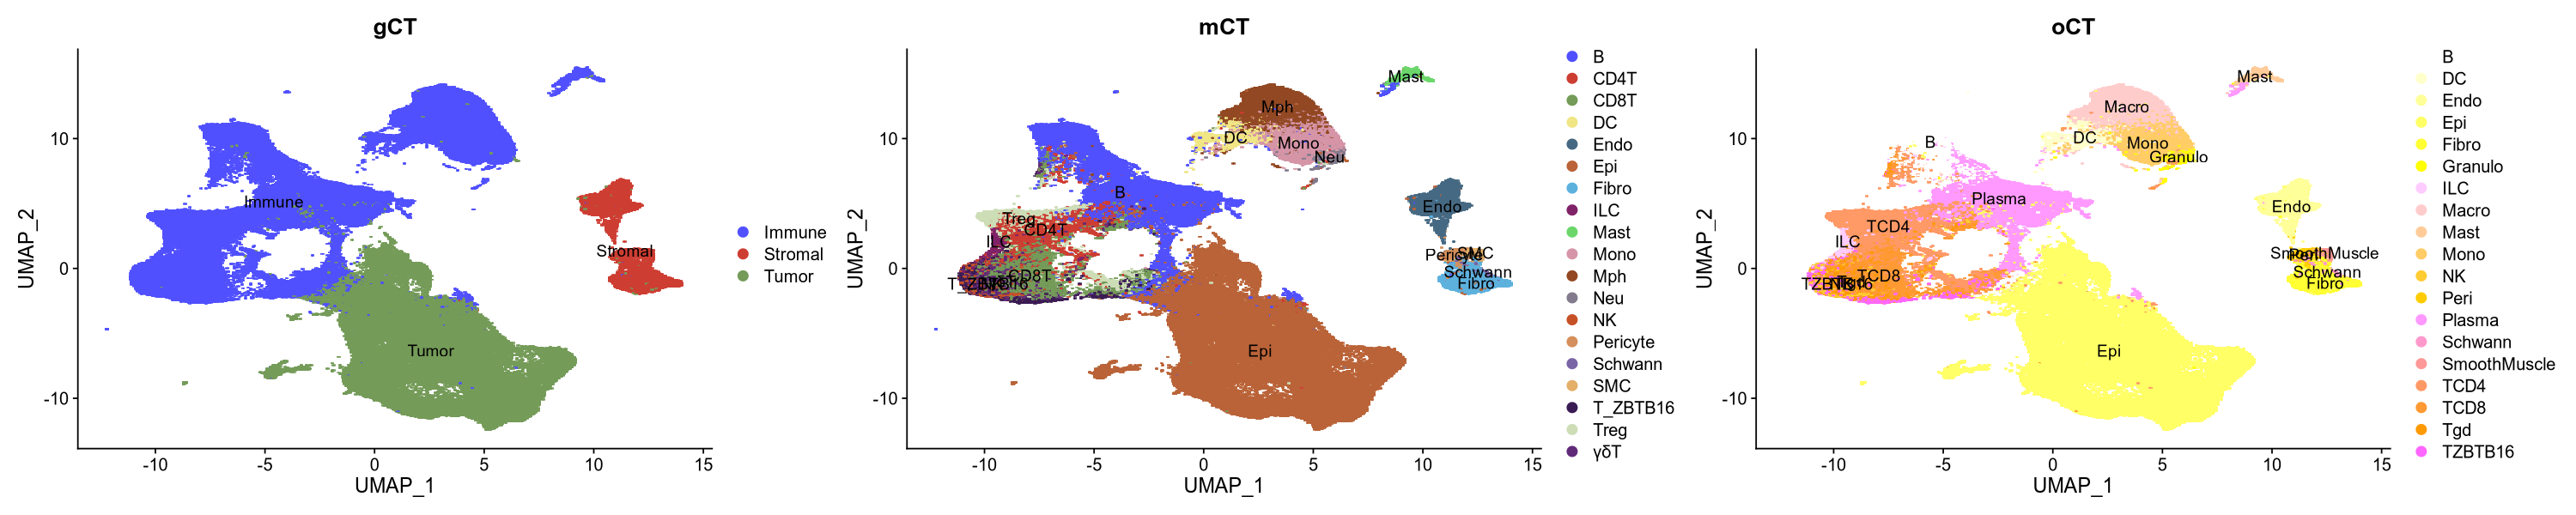

In [9]:
options(repr.plot.height = 5, repr.plot.width = 25)
DimPlot_scCustom(obj.CRC, pt.size = 1, group.by = "gCT", label = TRUE, label.size = 4, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.CRC, pt.size = 1, group.by = "mCT", label = TRUE, label.size = 4, colors_use = pal_igv("default")(51))|
# DimPlot_scCustom(obj.CRC, pt.size = 1, group.by = "dCT", label = TRUE, label.size = 4, colors_use = paletteer::paletteer_d('palettesForR::Web', 100))|
DimPlot_scCustom(obj.CRC, pt.size = 1, group.by = "oCT", label = TRUE, label.size = 4, colors_use = paletteer::paletteer_d('palettesForR::Web', 100))

# save

In [17]:
saveRDS(obj.CRC, "obj.CRC.use.rds")